In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import os
import math
from multiprocessing import Pool
from tqdm import tqdm
from scipy import stats
## init
mySpecie='Homo_sapiens'
#prealigned_dir='/cellar/users/btsui/all_seq_snp/Homo_sapiens_all_merged_snp.TCGA.prealigned.pickle'
targetted_align_dir='/cellar/users/btsui/all_seq_snp/Homo_sapiens_all_merged_snp.TCGA.pickle'
manifest_dir='/cellar/users/btsui/Project/METAMAP/notebook/RapMapTest/XGS_WGS/./tcga_lgg_wgs_bams.df.wxs_rnaseq.pickle'


In [3]:
targetted_df=pd.read_pickle(targetted_align_dir).loc["TCGA"]

In [4]:
#targetted_df

In [5]:
##bam-readcount sometime have duplicate rows, need deduplication
#%time targetted_df=targetted_df.groupby(targetted_df.index.names).first()

In [6]:
all_UUIDs=targetted_df.index.get_level_values('Run_digits').unique()

In [7]:
#883, 1427
print ('n UUID:',len(all_UUIDs))

n UUID: 1570


In [8]:
### use andrea mapping to map from TCGA barcode to UUID. 

In [9]:
manifest_df=pd.read_pickle(manifest_dir)

In [10]:
manifest_df['processed']=manifest_df.file_id.isin(all_UUIDs)

In [11]:
uuid_barcode_mapDf=pd.read_csv('/cellar/users/andreabc/GDC_barcodes/uuid_barcode_map.txt',sep='\t').set_index('file_id')

In [12]:
manifest_df['sample_barcode']=uuid_barcode_mapDf.loc[manifest_df.file_id]['sample_barcode'].values


In [13]:
m_data_category=manifest_df.data_category=='Raw Sequencing Data'
m_experimental_strategy=manifest_df['experimental_strategy'].isin(['RNA-Seq','WXS'])

In [14]:
manifest_df_sub=manifest_df[manifest_df['processed']&m_data_category&m_experimental_strategy]

In [15]:
tmpVC=manifest_df_sub['sample_barcode'].value_counts()
with_both=tmpVC.index[tmpVC==2]


In [16]:
len(with_both)

524

In [17]:
manifest_df_w_RNA_WXS=manifest_df_sub[manifest_df_sub.sample_barcode.isin(with_both)]


In [18]:
#g=manifest_df_w_RNA_WXS.groupby(['sample_barcode','experimental_strategy'])
#[manifest_df_sub['sample_barcode']=='TCGA-HT-A4DV-01A']

In [19]:
#manifest_df_sub

In [20]:
#queryBarcode='TCGA-HT-A4DV-01A'
#rnaseq_uuid=g.get_group((queryBarcode,'RNA-Seq'))['file_id'].iloc[0]
#wxs_uuid=g.get_group((queryBarcode,'WXS'))['file_id'].iloc[0]

In [21]:
#targetted_df.head()

In [22]:
query_chromosome, qeury_corrdinate='2',208248388
m_chr=targetted_df.index.get_level_values('Chr')=='2'
Pos_array=targetted_df.index.get_level_values('Pos')
window_size=10

m_pos=(Pos_array>(qeury_corrdinate-window_size))&(Pos_array<(qeury_corrdinate+window_size))

#


In [23]:
targetted_df_sub=targetted_df[m_pos]

In [24]:
rnaseq_uuids=manifest_df_w_RNA_WXS[manifest_df_w_RNA_WXS['experimental_strategy']=='WXS']['file_id'].unique()

m_uuid=targetted_df_sub.index.get_level_values('Run_digits').isin(rnaseq_uuids)


In [25]:
index_metaDf=targetted_df_sub.index.to_frame()

index_metaDf['sample_barcode']=manifest_df_w_RNA_WXS.set_index('file_id').loc[index_metaDf['Run_digits']]['sample_barcode'].values

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
multI=index_metaDf.set_index(['sample_barcode','Run_digits','Chr','Pos','base']).index


In [27]:
targetted_df_sub.index=multI

In [28]:
wxs_df=targetted_df_sub[m_uuid]#.loc[wxs_uuid]

In [29]:
groupings_L=['sample_barcode','Chr','Pos','base']

In [30]:
%time wxs_df=wxs_df.groupby(groupings_L).first()

CPU times: user 64 ms, sys: 4 ms, total: 68 ms
Wall time: 67.4 ms


In [31]:
rnaseq_uuids=manifest_df_w_RNA_WXS[manifest_df_w_RNA_WXS['experimental_strategy']=='RNA-Seq']['file_id'].unique()

m_uuid=targetted_df_sub.index.get_level_values('Run_digits').isin(rnaseq_uuids)

rnaseq_df=targetted_df_sub[m_uuid]#.loc[rnaseq_uuid]

In [32]:
%time rnaseq_df=rnaseq_df.groupby(groupings_L).first()

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 20.7 ms


In [33]:
mergedDf=pd.concat([ rnaseq_df,wxs_df],axis=1,keys=['rna-seq','wxs'])

In [34]:
mergedDf=mergedDf[~mergedDf.isnull().all(axis=1)]

## identify IDH1 mutations

In [35]:
#ref C
IDH1_corrdinate=208248388
mergedDf_subDf=mergedDf[mergedDf.index.get_level_values('Pos')==IDH1_corrdinate]

In [36]:
m_quality=(mergedDf_subDf['wxs']['AverageBaseQuality']>20)
ref_alt='T'
m_alt=(mergedDf_subDf.index.get_level_values('base'))==ref_alt

qualFilteredDf=mergedDf_subDf[m_quality]

In [37]:
unstackDf=qualFilteredDf.unstack()

In [38]:
unstackDf.head()

rna-seq                                      \
features                       ReadDepth                  AverageBaseQuality   
base                                   A      C   G     T                  A   
sample_barcode   Chr Pos                                                       
TCGA-CS-4938-01B 2   208248388       NaN   68.0 NaN  24.0                NaN   
TCGA-CS-4941-01A 2   208248388       NaN  235.0 NaN   NaN                NaN   
TCGA-CS-4942-01A 2   208248388       NaN  140.0 NaN  19.0                NaN   
TCGA-CS-4943-01A 2   208248388       NaN  179.0 NaN  73.0                NaN   
TCGA-CS-4944-01A 2   208248388       NaN   43.0 NaN  17.0                NaN   

                                                     wxs                   \
features                                       ReadDepth                    
base                               C   G     T         A      C   G     T   
sample_barcode   Chr Pos                                                    
TCGA-CS-4938-01B 2   208248388  37.0 NaN  38.0       NaN   87.0 NaN  29.0   
TCGA-CS-4941-01A 2   208248388  37.0 NaN   NaN       NaN  182.0 NaN   NaN   
TCGA-CS-4942-01A 2   208248388  38.0 NaN  38.0       NaN  192.0 NaN  46.0   
TCGA-CS-4943-01A 2   208248388  38.0 NaN  37.0       NaN  116.0 NaN  59.0   
TCGA-CS-4944-01A 2   208248388  37.0 NaN  37.0       NaN  149.0 NaN  43.0   

                                                                   
features                       AverageBaseQuality                  
base                                            A     C   G     T  
sample_barcode   Chr Pos                                           
TCGA-CS-4938-01B 2   208248388                NaN  29.0 NaN  29.0  
TCGA-CS-4941-01A 2   208248388                NaN  27.0 NaN   NaN  
TCGA-CS-4942-01A 2   208248388                NaN  25.0 NaN  28.0  
TCGA-CS-4943-01A 2   208248388                NaN  26.0 NaN  28.0  
TCGA-CS-4944-01A 2   208248388                NaN  27.0 NaN  28.0

In [39]:
from sklearn import metrics

In [40]:
import matplotlib.pyplot as plt

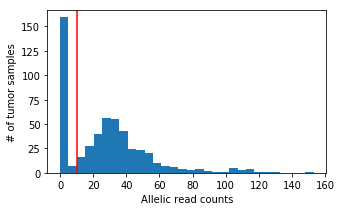

In [45]:

fig,ax=plt.subplots(figsize=(5,3))

unstackDf[('wxs','ReadDepth','T')].fillna(0).hist(bins=30,label='Minor alle',ax=ax)
#unstackDf[('wxs','ReadDepth','C')].fillna(0).hist(bins=30,ax=ax,
#                                                  label='Reference allele')
ax.axvline(x=10,c='red')
ax.set_ylabel('# of tumor samples')
#ax.legend([])
ax.set_xlabel('Allelic read counts')
ax.grid(False)


In [48]:
(unstackDf[('wxs','ReadDepth','T')]>0).sum()

351

In [41]:
asdasdas

NameError: name 'asdasdas' is not defined

In [ ]:
y_true=(>10)

In [ ]:
y_true.value_counts()

In [ ]:
print ('ROC AUC',metrics.roc_auc_score(y_true,
                      unstackDf[('rna-seq','ReadDepth','T')].fillna(0)))
precision, recall, thresholds=metrics.precision_recall_curve(y_true,
                      unstackDf[('rna-seq','ReadDepth','T')].fillna(0))
ax=pd.DataFrame({'precision':precision,'recall':recall}).plot(x='recall',y='precision')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
metrics.auc(recall,precision)
ax.set_title('IDH1 C>T mutation using RNAseq')

In [ ]:
import seaborn as sns

In [ ]:
qualFilteredDf[('wxs','ReadDepth')].index.get_level_values('base').value_counts()

In [ ]:
qualFilteredDf[('rna-seq','ReadDepth')].index.get_level_values('base').value_counts()

In [ ]:
qualFilteredDf[('rna-seq','ReadDepth')].index.get_level_values('base').value_counts()

In [ ]:
mergedDf_subDf

In [ ]:

qualFilteredDf['ReadDepth'],qualFilteredDf['wxs']>3

In [ ]:
##c 


In [ ]:
#qualFilteredDf[]

In [ ]:
unstackDf=qualFilteredDf['wxs'].unstack()['ReadDepth']

In [ ]:
#qualFilteredDf['wxs'].unstack()['ReadDepth']

In [ ]:
sns.jointplot(data=qualFilteredDf[qualFilteredDf.index.get_level_values('base')=='T'],x=('rna-seq','ReadDepth'),y=('wxs','ReadDepth'))


In [ ]:
#categorical_crossentropy

In [ ]:
### generate the correlation between the data 